In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import heapq
import cv2
import osmnx as ox
import networkx as nx
from math import radians, cos, sqrt


Lấy dữ liệu từ OSM 

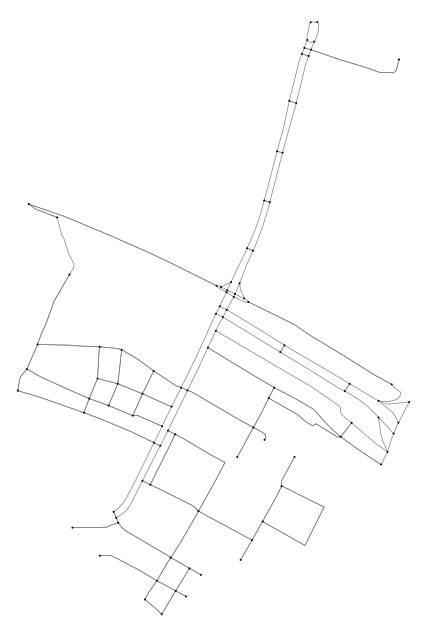

MultiDiGraph with 97 nodes and 214 edges
98031401 → 6661055810, key = 0, data = {'osmid': 708944664, 'oneway': True, 'lanes': '3', 'name': 'Phố Hoàng Cầu', 'highway': 'secondary', 'reversed': False, 'length': 4.906}
98031401 → 8823455179, key = 0, data = {'osmid': 1298270940, 'oneway': True, 'lanes': '1', 'name': 'Đường La Thành', 'highway': 'secondary', 'reversed': False, 'length': 16.908, 'geometry': <LINESTRING (105.826 21.021, 105.826 21.021, 105.826 21.021)>}
106108910 → 2174649945, key = 0, data = {'osmid': 1246265594, 'name': 'Phố Mai Anh Tuấn', 'highway': 'tertiary', 'oneway': False, 'reversed': False, 'length': 16.5}
106108910 → 106108917, key = 0, data = {'osmid': 1240127122, 'oneway': True, 'lanes': '3', 'name': 'Phố Hoàng Cầu', 'highway': 'secondary', 'reversed': False, 'length': 190.452, 'geometry': <LINESTRING (105.824 21.018, 105.824 21.018, 105.824 21.018, 105.824 21.017,...>}
106108910 → 5706871736, key = 0, data = {'osmid': 1246265594, 'name': 'Phố Mai Anh Tuấn', 'hig

In [10]:

place_name = "Ô Chợ Dừa, Đống Đa, Hà Nội, Việt Nam"

G = ox.graph_from_place(place_name, network_type="drive")

fig, ax = ox.plot_graph(G, node_size=2, edge_linewidth=0.5, bgcolor="white", node_color="black", edge_color="gray")

print(G)
edges = list(G.edges(data=True, keys=True))[:5]
for u, v, k, data in edges:
    print(f"{u} → {v}, key = {k}, data = {data}")

print(edges[:5])


In thông tin đồ thị


In [11]:

ox.save_graphml(G, "ochodua_dongda_hanoi_graph.graphml")  # Lưu dưới dạng file GraphML
O_cho_Dua_maps = ox.load_graphml("ochodua_dongda_hanoi_graph.graphml")  # Tải lại khi cần


Thiết lập Graph có dạng Graph [node] = {[node, distance],[] . . . }

In [ ]:
Edges =list (O_cho_Dua_maps.edges(data=True, keys=True))
Graph ={}
for node in O_cho_Dua_maps.nodes:
    Graph[node] = []
for node in O_cho_Dua_maps.nodes:
    for edges in Edges:
        if edges[0]== node:
                Graph[node].append([edges[1],edges[3]['length']]) 

for i in Graph.keys():
    print (i,Graph[i])
    print("\n")

98031401 [[6661055810, 4.906], [8823455179, 16.908]]


106108910 [[2174649945, 16.5], [106108917, 190.452], [5706871736, 179.60200000000003]]


106108917 [[2174649904, 15.483]]


106109203 [[2291014993, 62.082], [2291014992, 30.807], [318259614, 50.986000000000004]]


106109210 [[2174649904, 12.508], [318259614, 149.357], [106109949, 109.89]]


106109949 [[106109210, 109.88999999999999]]


309653659 [[5489009622, 16.486], [2050902835, 114.701]]


318258345 [[320237777, 45.68]]


318258347 [[320236991, 76.56400000000001]]


318259513 [[318259517, 149.733]]


318259517 [[2291014993, 50.335], [318259513, 149.733], [318259614, 63.614000000000004], [2291014994, 52.446]]


318259614 [[106109210, 149.357], [106109203, 50.986000000000004], [318259616, 127.39300000000001], [318259517, 63.614000000000004]]


318259616 [[2175126954, 130.039], [320236984, 143.585], [318259614, 127.393], [5707161170, 265.69399999999996]]


320236980 [[320236984, 53.726]]


320236984 [[320236980, 53.726], [318259616

Euclid distance tính theo Kinh độ và Vĩ độ

In [ ]:
def h1_euclid(current, goal):
    lat1 = O_cho_Dua_maps.nodes[current]['y']
    lon1 = O_cho_Dua_maps.nodes[current]['x']
    lat2 = O_cho_Dua_maps.nodes[goal]['y']
    lon2 = O_cho_Dua_maps.nodes[goal]['x']
    
    lat_mean = radians((lat1 + lat2) / 2)
    
    dx = (lon2 - lon1) * 111320 * cos(lat_mean)
    dy = (lat2 - lat1) * 111320
    
    return sqrt(dx**2 + dy**2)

def heuristic_bfs(start, goal):
    if start == goal:
        return 0
        
    parent_nodes = {}
    parent_nodes[start] = None
    frontier = []
    frontier.append(start)
    explored = []
    
    while frontier:
        current = frontier.pop(0)
        if current == goal:
            explored.append(current)
            break
        explored.append(current)
        for node in Graph[current]:
            if node[0] not in explored and node[0] not in frontier:
                frontier.append(node[0])
                parent_nodes[node[0]] = current
                
    if goal not in parent_nodes:
        return float('inf')
        
    return calculate_distance_bfs(parent_nodes, start, goal)

def calculate_distance_bfs(parent_nodes, start, goal):
    try:
        distance = 0
        current = goal
        while current != start:
            if current not in parent_nodes or parent_nodes[current] not in Graph:
                return float('inf')
            parent = parent_nodes[current]
            # Tìm khoảng cách giữa current và parent
            for node, dist in Graph[parent]:
                if node == current:
                    distance += dist
                    break
            current = parent
        return distance
    except KeyError:
        return float('inf')

SyntaxError: expected '(' (4127706652.py, line 13)

Heuristic + A* func

In [ ]:
def a_star(graph, start, goal):
    if start not in graph or goal not in graph:
        return None
    max_cutoff =  h1_euclid(start, goal)*1.5
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph}
    f_score[start] = h1_euclid(start, goal)
    # A star with heuristic calculate by euclid distance / mean_bfs (not recommended) 
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)
        for neighbor_data in graph[current]:
            neighbor = neighbor_data[0]
            if neighbor not in graph:  
                continue
            cost = neighbor_data[1]
            tentative_g_score = g_score[current] + cost
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + h1_euclid(neighbor, goal)
                if f_score[neighbor] > max_cutoff:
                    continue
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None

def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    total_path.reverse()
    return total_path

def path_to_edges(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]



Greedy Best First Search 

In [ ]:
def Greedy_best_first_search(graph, start, goal):
    if start not in graph or goal not in graph:
        return None
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    visited = set()
    
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)
        
        visited.add(current)
        
        for neighbor_data in graph[current]:
            neighbor = neighbor_data[0]
            if neighbor in visited:
                continue
            if neighbor not in came_from:
                came_from[neighbor] = current
                heapq.heappush(open_set, (h1_euclid(neighbor, goal), neighbor))
    
    return None


UCS  func

In [ ]:
def UCS(graph, start, goal):
    if start not in graph or goal not in graph:
        return None
        
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    visited = set()
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    
    while open_set:
        current_cost, current_node = heapq.heappop(open_set)  # Unpack properly
        
        if current_node == goal:
            return reconstruct_path(came_from, current_node)
        
        visited.add(current_node)  # Add just the node ID
        
        for neighbor, cost in graph[current_node]:  # Unpack neighbor tuple
            if neighbor in visited:
                continue
                
            new_cost = g_score[current_node] + cost
            if new_cost < g_score[neighbor]:
                g_score[neighbor] = new_cost
                came_from[neighbor] = current_node
                heapq.heappush(open_set, (new_cost, neighbor))
    
    return None

Mẫu với điểm đầu và điểm cuối random

In [ ]:

start = 98031401
goal = 11925365306
path = a_star(Graph, start, goal)
path_second = UCS(Graph, start, goal)
path_third = Greedy_best_first_search(Graph, start, goal)
print(f"Path found by A*: {path}")
print(f"Path found by UCS: {path_second}")
print(f"Path found by Greedy best first search: {path_third}")



Path found by A*: [98031401, 6661055810, 4961341860, 4961341865, 1904360482, 7837394427, 2291046243, 106108910, 106108917, 2174649904, 106109210, 318259614, 106109203, 2291014993, 11925365306]
Path found by UCS: [98031401, 6661055810, 4961341860, 4961341865, 1904360482, 7837394427, 2291046243, 106108910, 106108917, 2174649904, 106109210, 318259614, 106109203, 2291014993, 11925365306]


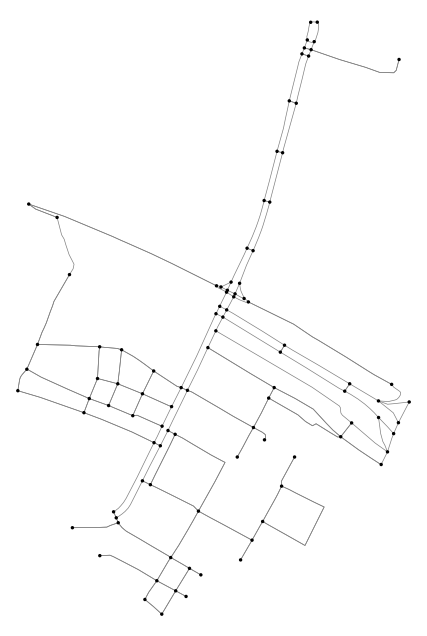

Tìm thấy đường đi
Đoạn 98031401 -> 6661055810: 4.906 meters
Đoạn 6661055810 -> 4961341860: 37.004000000000005 meters
Đoạn 4961341860 -> 4961341865: 19.534 meters
Đoạn 4961341865 -> 1904360482: 192.399 meters
Đoạn 1904360482 -> 7837394427: 50.083 meters
Đoạn 7837394427 -> 2291046243: 51.226 meters
Đoạn 2291046243 -> 106108910: 43.232 meters
Đoạn 106108910 -> 106108917: 190.452 meters
Đoạn 106108917 -> 2174649904: 15.483 meters
Đoạn 2174649904 -> 106109210: 12.508 meters
Đoạn 106109210 -> 318259614: 149.357 meters
Đoạn 318259614 -> 106109203: 50.986000000000004 meters
Đoạn 106109203 -> 2291014993: 62.082 meters
Đoạn 2291014993 -> 11925365306: 27.774 meters

Tổng khoảng cách: 907.03 meters


In [ ]:
# Vẽ đồ thị cơ bản
fig, ax = ox.plot_graph(O_cho_Dua_maps, 
                       node_size=6, 
                       edge_linewidth=0.5,
                       bgcolor="white",
                       node_color="black",
                       edge_color="gray")

# Kiểm tra và vẽ đường đi
if path and len(path) > 1:  # Kiểm tra path hợp lệ
    print("Tìm thấy đường đi")
    
    # Vẽ đường đi
    ox.plot_graph_route(O_cho_Dua_maps, 
                       path, 
                       route_linewidth=6, 
                       route_color="red", 
                       route_alpha=1,
                       fig=fig, 
                       ax=ax)
    
    # Tính tổng khoảng cách
    distance = 0
    for i in range(len(path) - 1):
        current = path[i]
        next_node = path[i + 1]
        # Lấy cạnh ngắn nhất nếu có nhiều cạnh
        edge_data = min(Graph[current], key=lambda x: x[1] if x[0] == next_node else float('inf'))
        if edge_data[0] == next_node:
            distance += edge_data[1]
            print(f"Đoạn {current} -> {next_node}: {edge_data[1]} meters")
    
    print(f"\nTổng khoảng cách: {distance:.2f} meters")
    plt.show()
else:
    print("Không tìm thấy đường đi hoặc đường đi không hợp lệ")

Check lại với Dijkstra

In [ ]:

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]  

def Dijkstra(start, goal, Graph):
    """ Thuật toán Dijkstra tìm đường đi ngắn nhất từ start đến goal """
    if start not in Graph or goal not in Graph:
        return None
    
    open_set = []
    heapq.heappush(open_set, (0, start))  

    came_from = {}  
    g_score = {node: float('inf') for node in Graph}  
    g_score[start] = 0  

    while open_set:
        current_cost, current = heapq.heappop(open_set)
        if current == goal:
            return reconstruct_path(came_from, current)

        for neighbor_data in Graph[current]:  
            neighbor, cost = neighbor_data  
            tentative_g_score = g_score[current] + cost
            if tentative_g_score < g_score[neighbor]:  
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (g_score[neighbor], neighbor))

    return None  

path = Dijkstra(98031401, 11925365306, Graph)
print(f"Path from {start} to {goal}:")
new_distance = 0
for i in range(len(path) - 1):
        current = path[i]
        next_node = path[i + 1]
        # Lấy cạnh ngắn nhất nếu có nhiều cạnh
        edge_data = min(Graph[current], key=lambda x: x[1] if x[0] == next_node else float('inf'))
        if edge_data[0] == next_node:
            new_distance += edge_data[1]
            print(f"Đoạn {current} -> {next_node}: {edge_data[1]} meters")
print(f"Path length: {new_distance:.2f} meters")


Path from 98031401 to 11925365306:
Đoạn 98031401 -> 6661055810: 4.906 meters
Đoạn 6661055810 -> 4961341860: 37.004000000000005 meters
Đoạn 4961341860 -> 4961341865: 19.534 meters
Đoạn 4961341865 -> 1904360482: 192.399 meters
Đoạn 1904360482 -> 7837394427: 50.083 meters
Đoạn 7837394427 -> 2291046243: 51.226 meters
Đoạn 2291046243 -> 106108910: 43.232 meters
Đoạn 106108910 -> 106108917: 190.452 meters
Đoạn 106108917 -> 2174649904: 15.483 meters
Đoạn 2174649904 -> 106109210: 12.508 meters
Đoạn 106109210 -> 318259614: 149.357 meters
Đoạn 318259614 -> 106109203: 50.986000000000004 meters
Đoạn 106109203 -> 2291014993: 62.082 meters
Đoạn 2291014993 -> 11925365306: 27.774 meters
Path length: 907.03 meters
